# Import Library

In [1]:
library(plyr)
library(dplyr)
library(glmnet)
library(tidyverse)
library(cowplot)
library(ggplot2)
library(GGally)
library(reshape2)
library(repr)
library(infer)
library(broom)
library(modelr)
library(caret)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix

Loaded glmnet 4.1-8

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ ggplot2   3.5.1     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()   masks plyr::arrange()
✖ purrr::compact()   masks plyr::compact()
✖ dplyr::count()     masks plyr::count()
✖ dplyr::desc()      masks plyr::desc()
✖ tidyr::expand()    masks Matrix::expand()
✖ dplyr::failwith()  masks plyr::failwith()
✖ dplyr::filter()    masks st

# Data Description

This dataset includes details about a company's employees, such as their demographics, job history, educational backgrounds, and employment-related characteristics. Although anonymized to preserve privacy, it offers insightful information about the workforce.

**Source**: The company's human resources department provided this dataset for the study and analysis.

**Objective**: This dataset can be used for various HR and workforce-related analyses, including employee retention, salary structure assessments, diversity and inclusion studies, and leave pattern analyses.

**Number of Observations**: 4653

**Variables**: The dataset includes 9 variables.

- `Education`: (Character) The educational qualifications of employees, including degree, institution, and field of study.

- `JoiningYear`: (Numerical) The year each employee joined the company, indicating their length of service.

- `City`: (Character) The location or city where each employee is based or works.

- `PaymentTier`: (Categorical) Categorization of employees into different salary tiers.

- `Age`: (Numerical) The age of each employee, providing demographic insights.

- `Gender`: (Categorical) Gender identity of employees, promoting diversity analysis. (Male or Female)

- `EverBenched`: (Categorical) Indicates if an employee has ever been temporarily without assigned work. (Yes or No)

- `ExperienceInCurrentDomain`: (Numerical) The number of years of experience employees have in their current field.

- `LeaveOrNot`: (Categorical) a target column (0: Not Leave, 1: Leave)

# Question

Is there a correlation between Payment Tier and Experience in Current Domain?

I am interested in determining if employees' experience in their current domain relates to their payment tier. Specifically, I will investigate whether there is a pattern or correlation between the number of years employees have worked in their field and the salary tier they are categorized into. 
- Explanatory Variable: `ExperienceInCurrentDomain`
- Response Variable: `PaymentTier`

To address this question:

I will use statistical methods to compute the correlation coefficient between `ExperienceInCurrentDomain` and `PaymentTier`.

I will create visualizations such as scatter plots or box plots to visualize the relationship.

This question is focused on **inference**. Its purpose is to determine whether there is a statistical correlation between employees' experience in their current field and their pay tier, allowing for broad conclusions about the information.

#  Exploratory Data Analysis and Visualization

In [2]:
employee_data <- read.csv("data/Employee.csv")
head(employee_data)

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
,<chr>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>
1,Bachelors,2017,Bangalore,3,34,Male,No,0,0
2,Bachelors,2013,Pune,1,28,Female,No,3,1
3,Bachelors,2014,New Delhi,3,38,Female,No,2,0
4,Masters,2016,Bangalore,3,27,Male,No,5,1
5,Masters,2017,Pune,3,24,Male,Yes,2,1
6,Bachelors,2016,Bangalore,3,22,Male,No,0,0


In [3]:
correlation_coefficient <- cor(employee_data$ExperienceInCurrentDomain, employee_data$PaymentTier)
correlation_coefficient

[1] 0.01831432

`geom_smooth()` using formula = 'y ~ x'


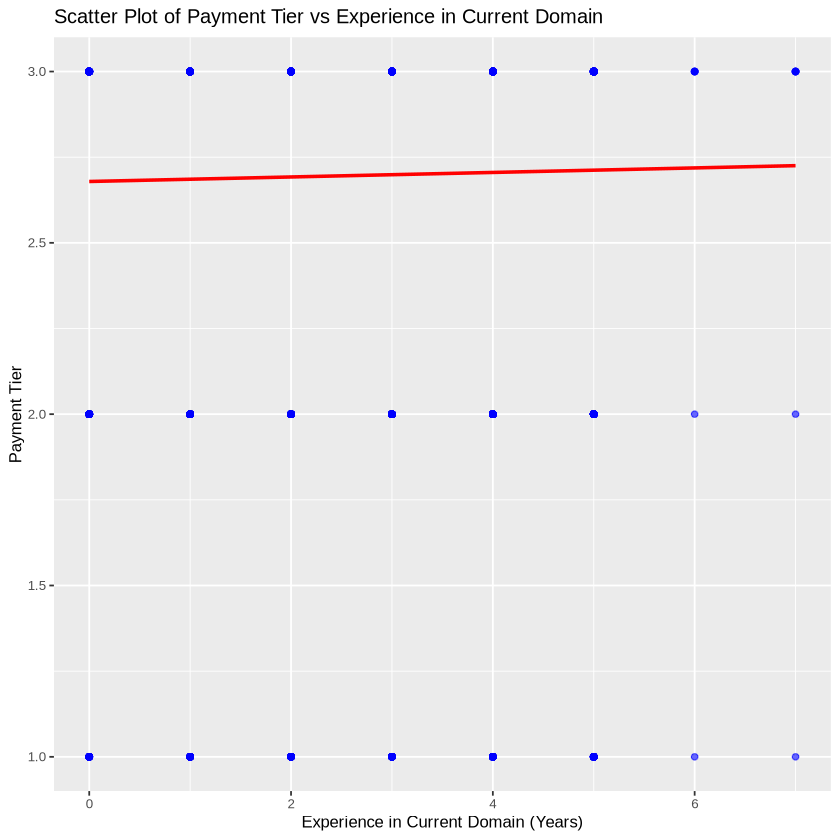

In [4]:
# Create a scatter plot for Experience in Current Domain vs Payment Tier
employee_data_plot <- ggplot(employee_data, aes(x = ExperienceInCurrentDomain, y = PaymentTier)) +
  geom_point(color = "blue", alpha = 0.6) +
  geom_smooth(method = "lm", color = "red", se = FALSE) +
  labs(
    title = "Scatter Plot of Payment Tier vs Experience in Current Domain",
    x = "Experience in Current Domain (Years)",
    y = "Payment Tier"
  ) +
  theme(text = element_text(size = 10))
employee_data_plot

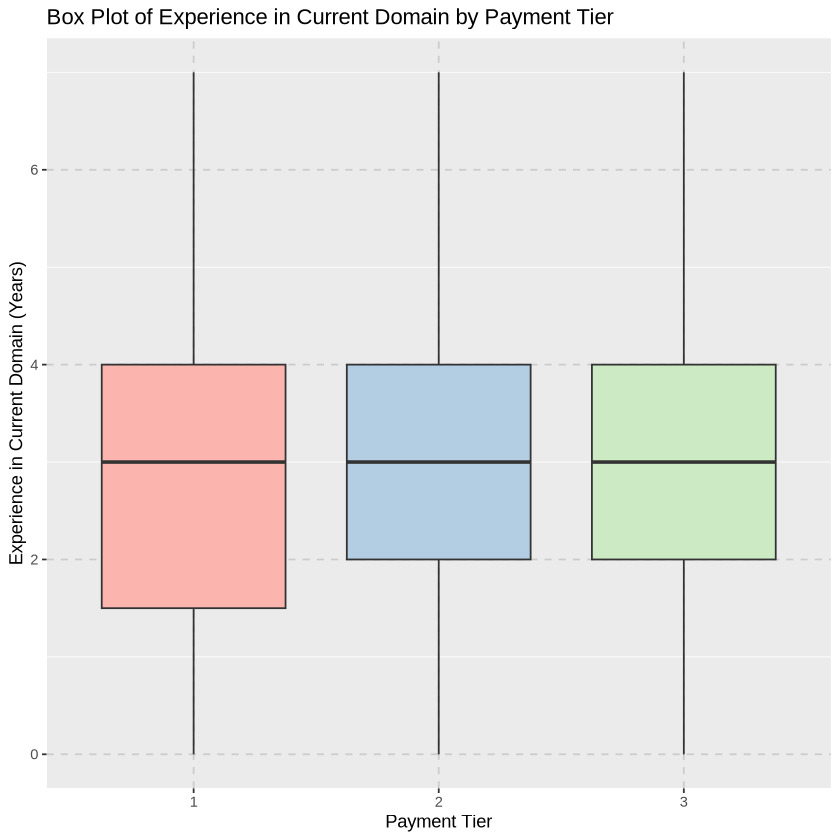

In [5]:
# Create a box plot for Experience in Current Domain by Payment Tier
employee_data_plot2 <- ggplot(employee_data, aes(x = factor(PaymentTier), y = ExperienceInCurrentDomain, fill = factor(PaymentTier))) +
  geom_boxplot() +
  labs(
    title = "Box Plot of Experience in Current Domain by Payment Tier",
    x = "Payment Tier",
    y = "Experience in Current Domain (Years)"
  ) +
  scale_fill_brewer(palette = "Pastel1") +
  theme(
    panel.grid.major = element_line(linetype = "dashed", color = "grey80"),
    legend.position = "none"
  )
employee_data_plot2

- The median experience is similar across all payment tiers.
- The range of experience appears similar across the tiers, with no significant differences in the spread or skewness of the data.

The correlation between PaymentTier and ExperienceInCurrentDomain is very low at $0.02$, indicating a negligible relationship between these variables. The scatter and box plot also demonstrates that there isn't any discernible pattern or trend pointing to a significant relationship between an employee's experience in their present field and their pay range. This suggests that in this dataset, employees' experience in their current domain does not have a strong influence on their payment tier.

# Methods and Plan

**Question change**: What is the relationship of these predictors (without `LeaveOrNot`) with each other and `LeaveOrNot`, and can these predictors be used to predict the odds of an employee leaving the company?

I will analyze the relationship between these predictors and our response `LeaveOrNot` and the relationship between these predictors to determine the presence of interactions. I will use these predictors to train a logistic model to predict the probability of an employee leaving a job using a test set.

### Method

1) Use a heatmap to find a correlation between predictors and individual predictors with the response `LeaveOrNot`.
2) Split our dataset into 0.7-0.3 training-testing splits. Use 123 seed.
3) Fit a logistic regression with the predictors we have using our training set.
4) Use backward selection to identify the model that best fits the data. Using our results, retrain a logistic regression.
5) Test our model against the confusion data and evaluate it for accuracy.

### Why is this method appropriate?

1) The response variable, `LeaveOrNot`, is binary (0: Not Leave, 1: Leave), making logistic regression an appropriate method.
2) Logistic regression provides interpretable coefficients, which will help understand the relationship between each predictor and the odds of an employee leaving.
3) Because of its processing efficiency, logistic regression is a beneficial fit for manageable and simple datasets.

### Which assumptions are required, if any, to apply the method selected?

1) Each observation must be independent of others.
2) Predictors must not be perfectly correlated. For example, `Education` and `JoiningYear` should not exhibit a perfect linear relationship.
3) To provide a reliable model estimate, numerical predictors whose ranges diverge substantially should be suitably scaled.

### What are the potential limitations or weaknesses of the method selected?

1) Non-linear relationships are complicated for logistic regression to model without adding interactions or polynomial components.
2) The results might be biased if the data violates the independence assumption (e.g., employees in the same city might influence each other).
4) Categorical variables like `City` and `Education` could have many levels, leading to overfitting or sparsity issues in parameter estimation.
5) Because logistic regression does not automatically choose the most relevant predictors, all predictors must be preprocessed and carefully selected.

# Computational Code and Output

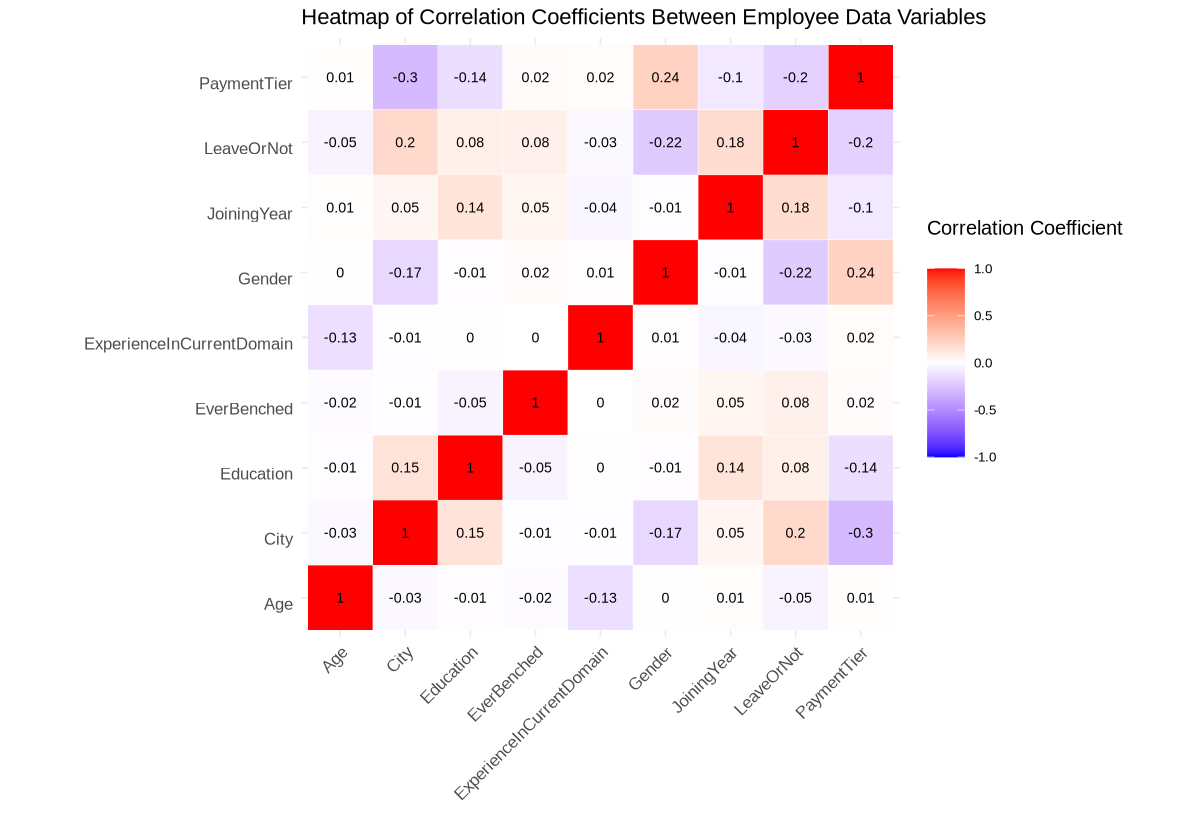

In [6]:
employee_numeric <- employee_data %>%
    mutate(Education = as.numeric(as.factor(employee_data$Education)),
           Gender = as.numeric(as.factor(employee_data$Gender)),
           EverBenched = as.numeric(as.factor(employee_data$EverBenched)),
           City = as.numeric(as.factor(employee_data$City)),
          )

corr_matrix_employee <- employee_numeric %>%
    cor() %>%
    as_tibble(rownames = 'var1') %>%
    pivot_longer(-var1, names_to = "var2", values_to = "corr")

options(repr.plot.width = 10, repr.plot.height = 7) 
employee_corr_plot <- 
    corr_matrix_employee %>%
    ggplot(aes(var1, var2)) +
    geom_tile(aes(fill = corr), color = "white") +
    scale_fill_gradient2(low = "blue", high = "red", mid = "white",
                         name = "Correlation Coefficient \n",
                         midpoint = 0,
                         space = "Lab",
                         limits = c(-1, 1)
                        ) +
    labs(title = "Heatmap of Correlation Coefficients Between Employee Data Variables", 
         x = "", y = "") +
    theme_minimal() +
    theme(
        axis.text.x = element_text(angle = 45, vjust = 1, size = 10, hjust = 1),
        axis.text.y = element_text(vjust = 1, size = 10, hjust = 1),
        legend.title = element_text(size = 12),
        legend.text = element_text(size = 8),
        legend.key.size = unit(0.8, "cm")
    ) +
    coord_fixed() + 
geom_text(aes(var1, var2, label = round(corr, 2)), color = "black", size = 3)

employee_corr_plot

Our heatmap results show that none of our predictors strongly correlate with each other or the response. This suggests that our predictors don't interact very much, and an additive model would be appropriate given this lack of interaction. As seen from the correlation heatmap above, we had many predictors to select from. I will split the dataset and perform LASSO regularization to shrink our model.

In [7]:
set.seed(123)
employee_data <- employee_data %>%
    mutate(ID = 1:n())
head(employee_data)

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot,ID
,<chr>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>
1,Bachelors,2017,Bangalore,3,34,Male,No,0,0,1
2,Bachelors,2013,Pune,1,28,Female,No,3,1,2
3,Bachelors,2014,New Delhi,3,38,Female,No,2,0,3
4,Masters,2016,Bangalore,3,27,Male,No,5,1,4
5,Masters,2017,Pune,3,24,Male,Yes,2,1,5
6,Bachelors,2016,Bangalore,3,22,Male,No,0,0,6


In [8]:
set.seed(123)

employee_train <- employee_data %>%
    slice_sample(prop = 0.7) 

employee_test <- employee_data %>%
    anti_join(employee_train, by = "ID")

employee_train <- employee_train %>%
    select(-ID)

employee_test <- employee_test %>%
    select(-ID)

model_matrix_X_train <- 
    model.matrix(LeaveOrNot ~ ., employee_train)[,-1]
matrix_Y_train <- 
    as.matrix(employee_train$LeaveOrNot, ncol = 1)

employee_cv_lambda_LASSO <- 
    cv.glmnet(
        x = model_matrix_X_train, 
        y = matrix_Y_train,
        alpha = 1,
        family = 'binomial',
        type.measure = 'auc',
        nfolds = 10)

employee_cv_lambda_LASSO


Call:  cv.glmnet(x = model_matrix_X_train, y = matrix_Y_train, type.measure = "auc",      nfolds = 10, alpha = 1, family = "binomial") 

Measure: AUC 

      Lambda Index Measure       SE Nonzero
min 0.000953    51  0.7261 0.009712      10
1se 0.018705    19  0.7165 0.009760       8

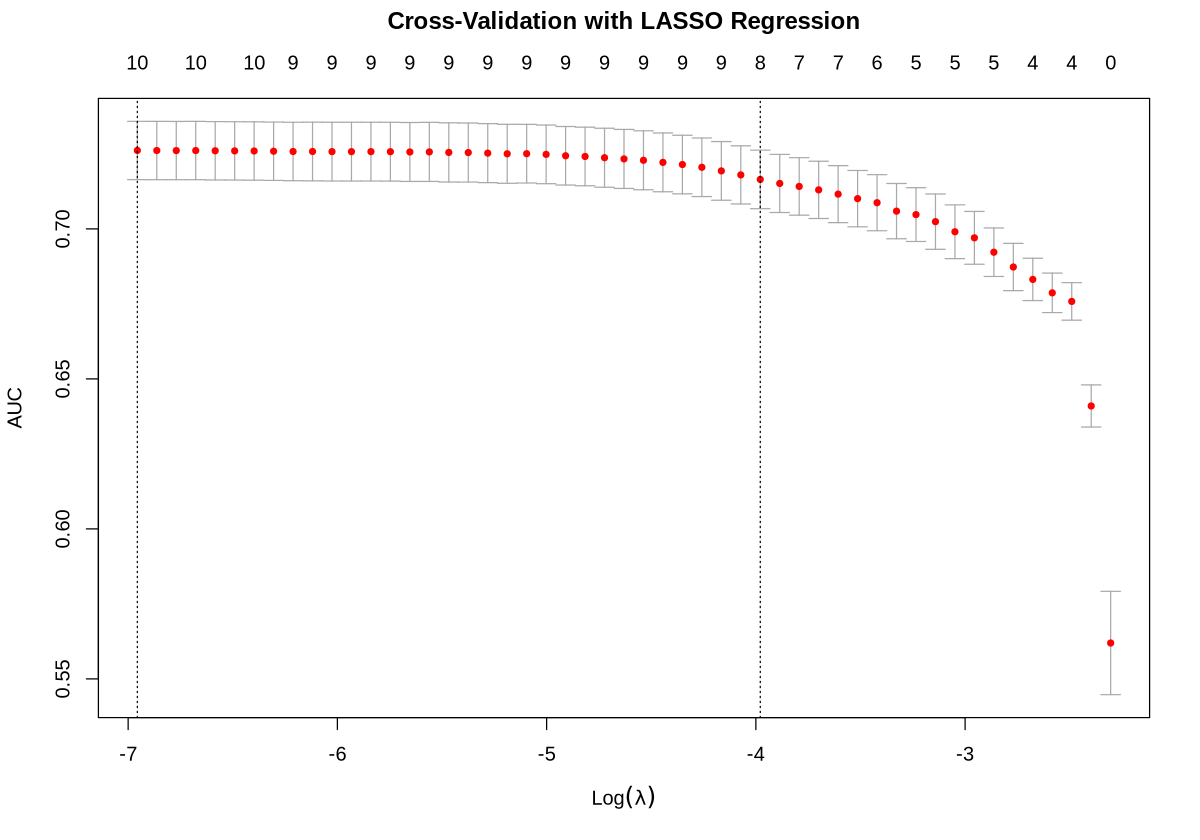

In [9]:
set.seed(123)

options(repr.plot.width = 10, repr.plot.height = 7)
plot(employee_cv_lambda_LASSO, main = "Cross-Validation with LASSO Regression\n\n")

In [10]:
set.seed(123)

employee_cv_lambda_1se_AUC_LASSO <- round(employee_cv_lambda_LASSO$lambda.1se, 4)
employee_cv_lambda_1se_AUC_LASSO

[1] 0.0187

In [11]:
set.seed(123)

employee_LASSO_1se_AUC <- 
    glmnet(
        x = model_matrix_X_train, 
        y = matrix_Y_train,
        alpha = 1,
        family = 'binomial',
        lambda = employee_cv_lambda_1se_AUC_LASSO
)

coef(employee_LASSO_1se_AUC)

11 x 1 sparse Matrix of class "dgCMatrix"
                                     s0
(Intercept)               -307.98838209
EducationMasters             0.36045783
EducationPHD                 .         
JoiningYear                  0.15303270
CityNew Delhi               -0.03194318
CityPune                     0.60061657
PaymentTier                 -0.23485939
Age                         -0.01101462
GenderMale                  -0.65689899
EverBenchedYes               0.28755730
ExperienceInCurrentDomain    .         

Using the training data, I fitted a logistic model based on the covariates identified above. Next, I predicted the testing data shown in a confusion matrix using the trained model.

In [12]:
set.seed(123)
model_matrix_X_test <- model.matrix(LeaveOrNot ~ ., employee_test)[, -1]
pred_prob <- predict(employee_LASSO_1se_AUC, newx = model_matrix_X_test, type = "response")
employee_pred_classes <- ifelse(pred_prob > 0.5, 1, 0)

conf_matrix <- confusionMatrix(factor(employee_pred_classes, levels = c(0, 1)),
                               factor(employee_test$LeaveOrNot, levels = c(0, 1)))
conf_matrix

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 851 334
         1  56 155
                                         
               Accuracy : 0.7206         
                 95% CI : (0.6963, 0.744)
    No Information Rate : 0.6497         
    P-Value [Acc > NIR] : 9.375e-09      
                                         
                  Kappa : 0.2937         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.9383         
            Specificity : 0.3170         
         Pos Pred Value : 0.7181         
         Neg Pred Value : 0.7346         
             Prevalence : 0.6497         
         Detection Rate : 0.6096         
   Detection Prevalence : 0.8489         
      Balanced Accuracy : 0.6276         
                                         
       'Positive' Class : 0              
                                         

[1] "Model Accuracy:  0.72"


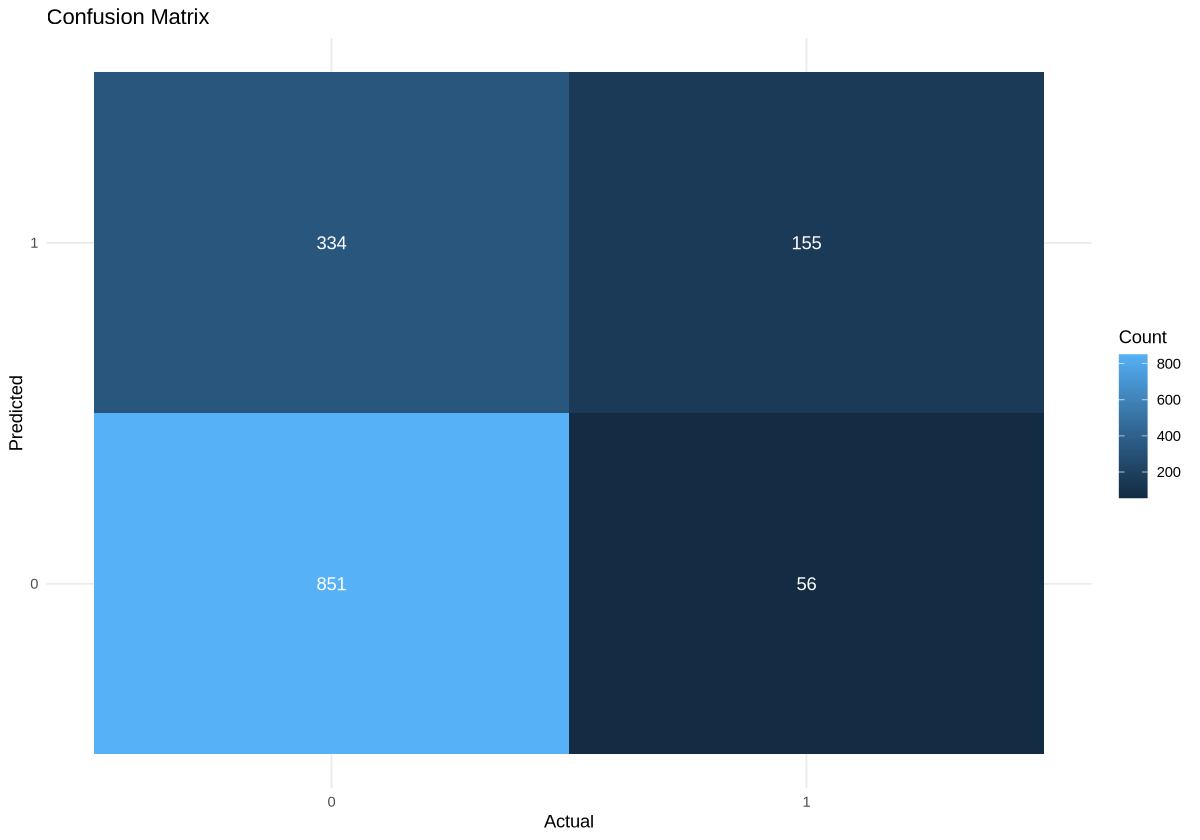

In [13]:
set.seed(123)
conf_matrix_table <- as.table(conf_matrix$table)
confusion <- as.data.frame(conf_matrix_table)
colnames(confusion) <- c("Actual", "Predicted", "Count")
ggplot(confusion, aes(x = Actual, y = Predicted, fill = Count)) +
  geom_tile() +
  geom_text(aes(label = Count), color = "white") +
  labs(title = "Confusion Matrix", x = "Actual", y = "Predicted") +
  theme_minimal()

accuracy <- sum(diag(conf_matrix_table)) / sum(conf_matrix_table)
print(paste("Model Accuracy: ", round(accuracy, 2)))

The model achieved an accuracy of 72%, indicating that it correctly classified 72% of the test data. The model correctly predicted 851 employees who would not leave and 155 employees who would. However, there is still room for improvement in the model. The model works on many false negatives, such as misclassifying employees who left as staying. To improve its accuracy, it might be helpful to balance the dataset (for example, by oversampling or undersampling), fine-tune the hyperparameters, or add more relevant features.